# Airbnb Recommender System

<img src=images/banner.jpg/>

## Overview

# Business Understanding

With an overabundance of information at our fingertips, decision-making can be quite overwhelming - especially when you are planning a vacation. Recommender systems help consumers find products tailored to their unique taste. In this project, **I will build a recommender system for Airbnb listings in Asheville, North Carolina**. 

The stakeholders for this project include the engineering team at Airbnb who would put the recommender system into production and the executives that will approve the project. This project is important to stakeholders because it will help generate more business. Users will be recommended listings that are personalized to their individual preferences. This will provide a more pleasurable experience to the users and increase the lieklihood of them booking additional vacations with Airbnb.

In this project, I will complete the following 3 tasks:

1. Create a **collaborative filtering model** to recommend 3 listings that an active user may like.
2. Incorporate **content-based filtering** to recommend listings to new users.
3. **Evaluate** the model to assess the efficacy of the recommendations.

# Data Understanding

The [data](https://insideairbnb.com/get-the-data/) has been extracted from Airbnb. Two datasets were used in this project:
1. listings.csv.gz: 3031 entries of unique listings. Each listing includes detailed information, including host information, price, availability, rooms, and reviews. This dataset will be trimmed to include only what will be listed in the recommendations.
2. reviews.csv.gz: 331718 entries of unique reviews. This dataset includes the following columns - listing_id, id, date, reviewer_id, reviewer_name, comments. The reviews are listed as comments, not numerical ratings. 

First I will import all the necessary libraries for EDA, data cleaning and modeling.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV

Next I will import each of the datasets, preview the first 5 rows of the data, and investigate an overview of the data to view the data types, columns, and number of nulls. I also will preview a full comment to determine how it can be utilized for machine learning. 

In [2]:
# Import listings data and preview first 5 rows
listings_df = pd.read_csv('data/listings.csv')
listings_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,155305,https://www.airbnb.com/rooms/155305,20240621025915,2024-06-21,city scrape,Cottage! BonPaul + Sharky's Hostel,NaN,"We are within easy walk of pubs, breweries, mu...",https://a0.muscache.com/pictures/8880711/cf38d...,746673,...,4.75,4.92,4.58,NaN,f,8,2,2,4,2.78
1,156805,https://www.airbnb.com/rooms/156805,20240621025915,2024-06-21,city scrape,"Private Room ""Ader"" at BPS Hostel",NaN,"Easy walk to pubs, cafes, bakery, breweries, l...",https://a0.muscache.com/pictures/23447d55-fa7e...,746673,...,4.61,4.84,4.46,NaN,t,8,2,2,4,0.43
2,156926,https://www.airbnb.com/rooms/156926,20240621025915,2024-06-21,city scrape,"Mixed Dorm ""Top Bunk #1"" at BPS Hostel",This is a top bunk in the mixed dorm room<br /...,NaN,https://a0.muscache.com/pictures/5fa7178e-c514...,746673,...,4.77,4.78,4.78,NaN,t,8,2,2,4,2.17
3,197263,https://www.airbnb.com/rooms/197263,20240621025915,2024-06-21,city scrape,Tranquil Room & Private Bath,"This is a comfy, peaceful and clean room with ...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,961396,...,4.93,4.85,4.98,NaN,f,2,1,1,0,0.57
4,209068,https://www.airbnb.com/rooms/209068,20240621025915,2024-06-21,city scrape,Terrace Cottage,NaN,Our beautiful Grove Park Historic District clo...,https://a0.muscache.com/pictures/1829924/9f3bf...,1029919,...,4.98,4.94,4.79,NaN,f,1,1,0,0,0.42


In [3]:
# View the overall shape, dtypes and null counts for each column in train data
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3031 entries, 0 to 3030
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3031 non-null   int64  
 1   listing_url                                   3031 non-null   object 
 2   scrape_id                                     3031 non-null   int64  
 3   last_scraped                                  3031 non-null   object 
 4   source                                        3031 non-null   object 
 5   name                                          3031 non-null   object 
 6   description                                   2939 non-null   object 
 7   neighborhood_overview                         2205 non-null   object 
 8   picture_url                                   3031 non-null   object 
 9   host_id                                       3031 non-null   i

I will explore the distribution of prices of Asheville Airbnb prices. Price can be a determining factor when booking an Airbnb. If we are recommending listings well beyond someone's budget just because they have similar interests to another user, the recommendation system will not be helpful and the user will not book the listings.

In [9]:
# Convert prices to float
listings_df['price'] = listings_df['price'].str.replace('[$,]', '', regex=True).astype(float)

In [17]:
# View satistical distribution of prices
listings_df['price'].describe()

count    2892.000000
mean      189.169087
std       193.268821
min        11.000000
25%        99.000000
50%       137.000000
75%       214.000000
max      5520.000000
Name: price, dtype: float64

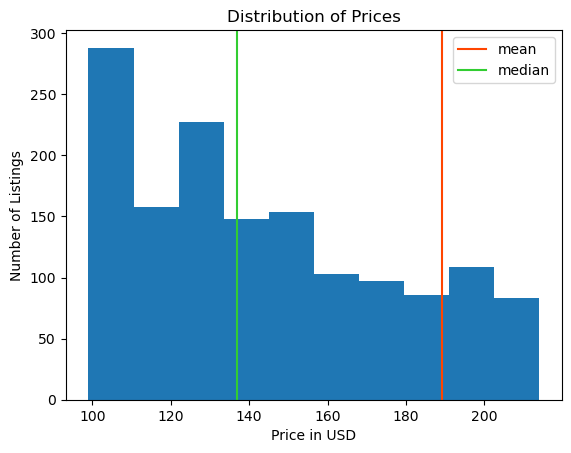

In [35]:
# Plot a histogram of the distribution of listing prices between the first and third quartiles
plt.hist(x=listings_df['price'],bins=10, range=(99,214))
plt.title('Distribution of Prices')
plt.xlabel('Price in USD')
plt.ylabel('Number of Listings')
plt.axvline(listings_df['price'].mean(), c='orangered', label='mean')
plt.axvline(listings_df['price'].median(), c='limegreen', label='median')
plt.legend();

The bulk of the Asheville Airbnb listings fall between \\$99 and \\$214 per night. There are outliers, with the minimum price of \\$11 and the maximum price of \\$5,520. The distriution is skewed right. The mean price is approximately \\$189, which is not an accurate representation of the data, as the much more expensive listings have contributed to a higher mean. The median of the data is \\$137, which is a more accurate depiction of the center of the data. 

In [4]:
# Import reviews data and preview first 5 rows
reviews_df = pd.read_csv('data/reviews.csv')
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,155305,409437,2011-07-31,844309,Jillian,We had a wonderful time! The cottage was very ...
1,155305,469775,2011-08-23,343443,Katie,Place was great! Can't really speak to the ins...
2,155305,548257,2011-09-19,1152025,Katie,We had a great time! The cabin was nice and a...
3,155305,671470,2011-10-28,1245885,Jason,Clean and comfortable room with everything you...
4,155305,1606327,2012-07-01,1891395,Craig,The cabin was solid for an overnight stay. It ...


In [5]:
# View an example review
reviews_df.comments[1]

"Place was great! Can't really speak to the inside as we only went inside to check in, but looked nice and friendly. We stayed in the cabin in the back and it was lovely. Private and cute, user-friendly. Hot tub was also really good. Spoke with other guests who were all really friendly and interesting people. Great area of town - easy walk to pizza, bars, shops, and coffee. Really loved staying here. \r<br/>Suggestion: Bring an extra towel, plates or something to use if you're eating in (there's a small kitchen). Maybe another fan if it's really hot. Bed is not really that comfortable if you're really tall. Thanks!!"

In [6]:
# View the overall shape, dtypes and null counts for each column in train data
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331718 entries, 0 to 331717
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     331718 non-null  int64 
 1   id             331718 non-null  int64 
 2   date           331718 non-null  object
 3   reviewer_id    331718 non-null  int64 
 4   reviewer_name  331717 non-null  object
 5   comments       331653 non-null  object
dtypes: int64(3), object(3)
memory usage: 15.2+ MB


In [7]:
# Compare number of users to number of listings
print('Number of Users:', reviews_df['reviewer_id'].nunique())
print('Number of Listings:', reviews_df['listing_id'].nunique())

Number of Users: 295659
Number of Listings: 2812


In [8]:
# View value counts for reviewer ids to see if users reviewed multiple listings
reviews_df['reviewer_id'].value_counts()

reviewer_id
54752689     19
151320586    19
20741182     18
7502408      17
418200641    17
             ..
40047901      1
259668211     1
346490041     1
242974366     1
478551791     1
Name: count, Length: 295659, dtype: int64

# Data Preparation

To prepare the data for machine learning, I will compute the following steps:
1. Select columns to use and clean each dataframe.
2. Use VADER SentimentIntensityAnalyzer to convert review comments to nuerical values (compound scores) in preparation for machine learning. Create a new column with these values.
3. Explore the statistical distribution of compound scores of the reviews.

## Data Cleaning

### Listings DataFrame

I will create a new dataframe, `recommender_cols_df` that include only the columns I want to keep from `listings_df`. These columns are 'id', 'listing_url', 'name', 'description', 'picture_url', 'room_type', 'price'. `id` must be kept to link the listing from this dataframe to the listing id in `reviews_df`. The remaining columns are kept to to populate once the user is provided the 3 recommendations. For more information on the listing, they can click the URL link to visit the listing on Airbnb.

In [9]:
# Create a new dataframe with only necessary columns
columns_to_keep = ['id', 'listing_url', 'name', 'description', 'picture_url', 'room_type', 'price']
recommender_cols_df = listings_df[columns_to_keep]

In [10]:
# Check nulls for new dataframe
recommender_cols_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3031 entries, 0 to 3030
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           3031 non-null   int64 
 1   listing_url  3031 non-null   object
 2   name         3031 non-null   object
 3   description  2939 non-null   object
 4   picture_url  3031 non-null   object
 5   room_type    3031 non-null   object
 6   price        2892 non-null   object
dtypes: int64(1), object(6)
memory usage: 165.9+ KB


The `description` and `price` columns have some nulls but we will keep it as is. This dataframe is going to be used only to provide information to the user on the listings that are recommended. Every listing has a listing url, therefore the user can click the url to get additional information on the listing and book the listing.

### Reviews DataFrame

`reviews_df` is composed of unique reviews. There may be multiple reviews for any listing and any user may have left reviews for various listings. First, I will check for any duplicate reviews of the same listing left by the same reviewer. 

Next, I will remove any entries with null comments. An entry without a comment does not provide us any information that will help us recommend listings.

Then I will drop the following columns from `reviews_df`: 'id', 'date', 'reviewer_name'. The dataframe remains with:
- 'listing_id' in order to link the listing to the listing information in `recommender_cols_df`,
- 'reviewer_id' to identify users and recommend similar interest listings,
- 'comments' which I will use VADER SentimentIntensityAnalyzer to convert the text to a compound score to scale the reviews as positive, negative, or neutral.

In [11]:
# Check duplicates
reviews_df.duplicated('id').value_counts()

False    331718
Name: count, dtype: int64

In [12]:
# Check columns with no comments
reviews_df[reviews_df['comments'].isnull()]

,listing_id,id,date,reviewer_id,reviewer_name,comments
7883,13112074,328260078,2018-09-25,121268935,Tiffany,NaN
22461,5696919,441087924,2019-04-21,140470172,Michael,NaN
24521,14352724,557206634,2019-10-31,40817729,Jessica,NaN
30131,6145162,759901200,2021-05-18,37832155,Kayla,NaN
33003,6234618,311153650,2018-08-20,74602012,Eileen,NaN
...,...,...,...,...,...,...
278579,49232318,454954076455043203,2021-09-19,420262398,Carrie,NaN
284092,51843113,790633688751657337,2022-12-26,363935612,Ruby,NaN
292236,554287486404930872,902919400570368908,2023-05-30,227046934,Bryan,NaN
305037,53810860,749943288289375768,2022-10-31,90622309,Gerald,NaN


We can delete the rows with no comments. They don't provide any information on what these users thought about the particular listings and there are only 65 of them.

In [13]:
# Drop nulls
reviews_df.dropna(subset='comments', inplace=True)

In [14]:
# Drop unecessary columns
reviews_df.drop(axis=1, columns=['id', 'date', 'reviewer_name'], inplace=True)

In [15]:
# Merge the two datasets on `id` and `listing_id`
airbnb_data = pd.concat([recommender_cols_df, reviews_df], axis=1, keys=)

# Preview merged dataset
airbnb_data.head()

SyntaxError: invalid syntax (2500307406.py, line 2)

## Feature Engineering

To create a recommender model, I must convert the review comments to numerical value. I will use the **VADER** (Valence Aware Dictionary and sEntiment Reasoner) SentimentIntensityAnalyzer. This is a pretrained lexicon and rule-based sentiment analysis tool. I chose this library due to its ease of use and because it does not require any training data. I will create a new column 'compound_scores' which the sentiment results of each comment. The **compound scores range from -1 (most negative) to 1 (most positive)**. **Neutral sentiments range from values greater than -0.05 to values less than 0.05**. These scores will be used to recommend listing to similar users.

In [16]:
# Instantiate analyzer
analyzer = SentimentIntensityAnalyzer()

# Create new column `compound_scores` to list compound scores of text comments
reviews_df['compound_scores'] = [analyzer.polarity_scores(x)['compound'] for x in reviews_df['comments']]

In [17]:
# Preview results
reviews_df.head()

,listing_id,reviewer_id,comments,compound_scores
0,155305,844309,We had a wonderful time! The cottage was very ...,0.8830
1,155305,343443,Place was great! Can't really speak to the ins...,0.9954
2,155305,1152025,We had a great time! The cabin was nice and a...,0.9819
3,155305,1245885,Clean and comfortable room with everything you...,0.9775
4,155305,1891395,The cabin was solid for an overnight stay. It ...,0.8807


In [18]:
# View statistical distribution of compound scores
reviews_df['compound_scores'].describe()

count    331653.000000
mean          0.853374
std           0.197392
min          -0.993900
25%           0.826800
50%           0.922600
75%           0.963400
max           0.999700
Name: compound_scores, dtype: float64

#Include overview of statistical distribution

# Modeling

## Baseline Model

###TRAIN TEST SPLIT FIRST

In [ ]:
# Instantiate baseline SVD model
baseline_model = knnBasic()


## Modeling Iterations

## Final Model

# Conclusion

## Recommendations

## Limitations

1. New users do not have a baseline on listing preferences, as they have not left any reviews. 

## Next Steps